# Convolutional Networks

![Status](https://img.shields.io/static/v1.svg?label=Status&message=Finished&color=brightgreen)
[![Source](https://img.shields.io/static/v1.svg?label=GitHub&message=Source&color=181717&logo=GitHub)](https://github.com/particle1331/ok-transformer/blob/master/docs/nb/dl/03-cnn.ipynb)
[![Stars](https://img.shields.io/github/stars/particle1331/ok-transformer?style=social)](https://github.com/particle1331/ok-transformer)

---

**Readings:** [[CS231n]](https://cs231n.github.io/convolutional-networks/) [[NLPCourse]](https://lena-voita.github.io/nlp_course/models/convolutional.html) {cite}`raschka2022` [[Keras Guides]](https://keras.io/guides/transfer_learning/#finetuning)

## Introduction

In this notebook, we will apply **convolutions** to images and text embeddings. A convolutional layer extracts features by applying the same operation to local parts of an input. This is motivated by the fact that objects in an image can be translated without changing its meaning. This also means that weights can be shared allowing for smaller, more efficient networks. A shallow convolutional layer learns detectors of simple patterns. But stacking convolutional layers into a deep network allows it to learn hierarchical patterns that generalize well to test data.

Let us visualize weights on the first layer of AlexNet {cite}`imagenet-paper`:

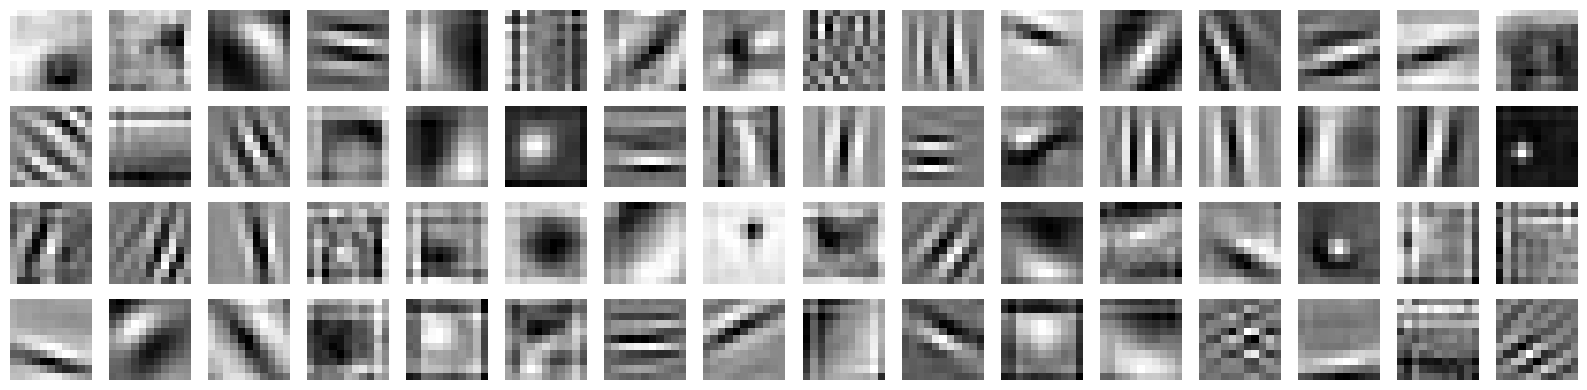

In [1]:
import torchvision.models as models
import matplotlib.pyplot as plt

alexnet = models.alexnet(weights=models.AlexNet_Weights.DEFAULT)

def plot_alexnet_weights(layer_index):
    weights = alexnet.features[layer_index].weight.data.detach().numpy()
    weights = (weights - weights.min()) / (weights.max() - weights.min())

    fig, ax = plt.subplots(4, 16, figsize=(16, 4))
    for i in range(64):
        j, k = divmod(i, 16)
        ax[j, k].imshow(weights[i, 0, :, :], cmap="gray")
        ax[j, k].axis('off')

    fig.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    fig.tight_layout()

plot_alexnet_weights(layer_index=0)

And weights in a deeper layer:

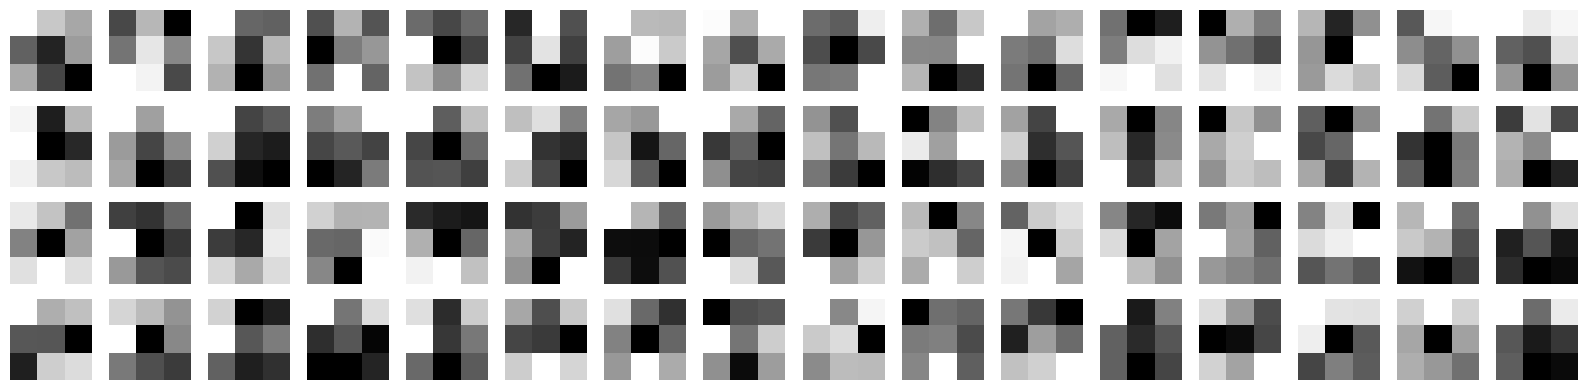

In [2]:
plot_alexnet_weights(layer_index=10)

In [3]:
del alexnet

<br>

Importing modules:

In [4]:
import random
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from matplotlib_inline import backend_inline

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

DATASET_DIR = Path("./data/").resolve()
DATASET_DIR.mkdir(exist_ok=True)
warnings.simplefilter(action="ignore")
backend_inline.set_matplotlib_formats("svg")
matplotlib.rcParams["image.interpolation"] = "nearest"

RANDOM_SEED = 0
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

print(torch.__version__)
print(torch.backends.mps.is_built())
DEVICE = torch.device('mps')

2.0.0
True


## Convolution operation

Suppose we want to classify cat images using a linear model. Flattening the image into a vector 
and feeding it into a fully-connected network does not seem to be the best approach.
In practice, the resulting input vector would be too long resulting in a very large weight matrix.
Moreover, it will consider each pixel independently. Note that for images
nearby pixels are correlated, while distant pixels are not ({numref}`cat-conv`). This motivates 
only mixing nearby pixels in a linear combination resulting in a very sparse banded weight matrix ({numref}`toeplitz`).

```{figure} ../../img/cat.png
---
width: 500px
name: cat-conv
---
Nearby pixels combine to form meaningful features of an image. [Source](https://www.nationalgeographic.com/animals/mammals/facts/domestic-cat)
```

Let $\boldsymbol{\mathsf X}$ be an $n \times n$ input image and $\boldsymbol{\mathsf{S}}$ be the $m \times m$ output feature map. The banded weight matrix reduces the nonzero entries of the weight matrix from $m^2 n^2$ to $m^2{k}^2$ where a local region of $k \times k$ pixels in the input image are mixed. If the feature detector is translationally invariant across the image,
then the weights in each band are **shared**. This further reduces the number of weights to $k^2$!
The resulting linear operation is called a **convolution** in two spatial dimensions:


```{math}
:label: 2dconv
\boldsymbol{\mathsf{S}} = (\boldsymbol{\mathsf X} \circledast \boldsymbol{\mathsf{K}})_{ij} = \sum_{x = 0}^{{k}-1} \sum_{y=0}^{{k}-1} {\boldsymbol{\mathsf X}}_{i + x, j + y} \, {\boldsymbol{\mathsf{K}}}_{xy}.
```


Observe that spatial ordering of the pixels in the input $\boldsymbol{\mathsf X}$ is somewhat preserved in the output $\boldsymbol{\mathsf{S}}.$ This is nice since we want spatial information and orientation across a stack of convolution operations to be preserved in the final output.

```{margin}
Figure source:<br>
[`deepimaging.github.io`](https://deepimaging.github.io/lectures/lecture_9_intro_to_CNN's.pdf)
```
```{figure} ../../img/conv-cat-99.png
---
width: 30em
name: toeplitz
---
Banded Toeplitz matrix for classifying cat images. The horizontal vectors contain the same pixel values. Note that there can be multiple bands for a 2D kernel. See this [SO answer](https://stackoverflow.com/a/44039201/1091950).
```

```{figure} ../../img/nn/no_padding_no_strides.gif
---
---
The following shows a convolution operation with 3 × 3 kernel for 2D input. This essentially visualizes {eq}`2dconv`. Source: https://github.com/vdumoulin/conv_arithmetic
```


### Convolution layer

The **convolution layer** extends the convolution operation to handle feature maps with **multiple channels**. Similarly, the output feature map has channels as this adds a further semantic dimension. For an RGB image, a convolution layer learns three 2-dimensional kernels $\boldsymbol{\mathsf{K}}_{lc}$ for each **output channel**, which can be thought of as a **feature extractor**. Note that features across input channels are blended by the kernel. This is expressed by the following formula:

$$
\begin{aligned}
{\bar{\boldsymbol{\mathsf X}}}_{lij}
&= {\boldsymbol{\mathsf u}}_{l} + \sum_{c=0}^{{c}_\text{in}-1} ({\boldsymbol{\mathsf X}}_{[c,\,:,\, :]} \circledast {\boldsymbol{\mathsf K}}_{[l,\,{c},\, :,\,:]})_{ij} \\
&= {\boldsymbol{\mathsf u}}_{l} + \sum_{c=0}^{{c}_\text{in}-1}\sum_{x = 0}^{{k}-1} \sum_{y=0}^{{k}-1} {\boldsymbol{\mathsf X}}_{c,\, i + x,\, j + y} \, {\boldsymbol{\mathsf K}}_{lcxy} \\
\end{aligned}
$$

for $l = 0, \ldots, {c}_\text{out}-1$. The input and output tensors $\boldsymbol{\mathsf{X}}$ and $\bar{\boldsymbol{\mathsf{X}}}$ have the same dimensionality and semantic structure which makes sense since we want to stack convolutional layers as modules, and the kernel $\boldsymbol{\mathsf{K}}$ has shape $({c}_\text{out}, {c}_\text{in}, {k}, {k}).$ The resulting feature maps inherit the spatial ordering in its inputs along the spatial dimensions.

**Remark.** This is called 2D convolution since it processes inputs with 2 spatial dimensions indexed by $i$ and $j$. Meanwhile, 1D convolutions used for processing sequential data has 1 dimension (e.g. for time).

In [5]:
!wget -O ./data/shorty.png "https://raw.githubusercontent.com/particle1331/ok-transformer/dev/docs/img/shorty.png"

--2024-01-08 18:10:44--  https://raw.githubusercontent.com/particle1331/ok-transformer/dev/docs/img/shorty.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 902795 (882K) [image/png]
Saving to: ‘./data/shorty.png’

./data/shorty.png   100%[===================>] 881.64K  3.69MB/s    in 0.2s    

2024-01-08 18:10:44 (3.69 MB/s) - ‘./data/shorty.png’ saved [902795/902795]



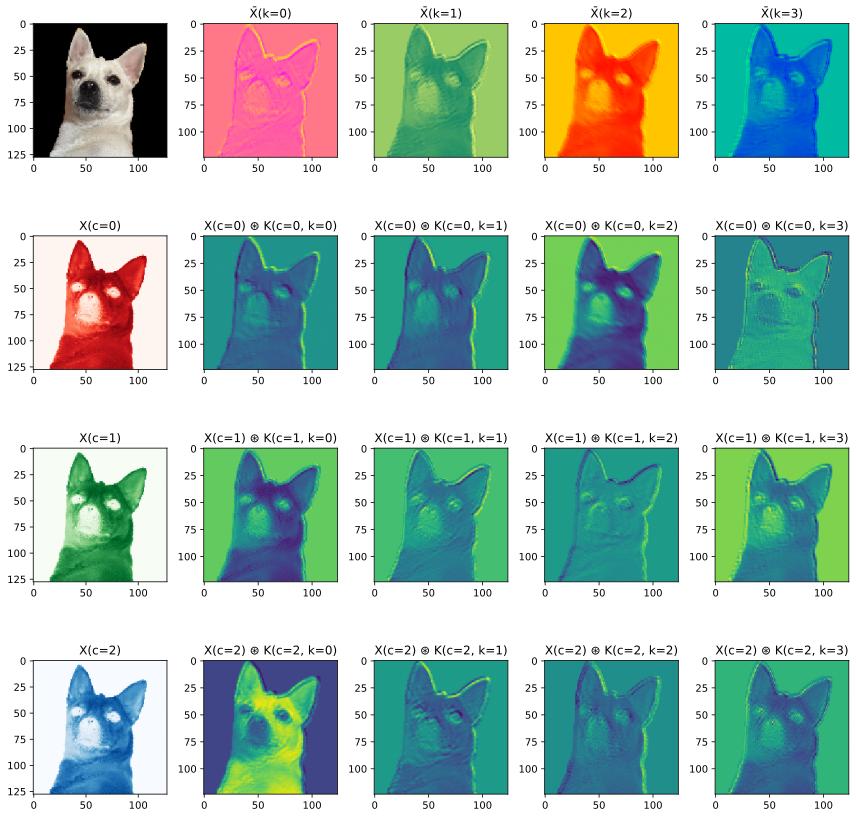

In [6]:
from torchvision.io import read_image
import torchvision.transforms.functional as fn

def convolve(X, K):
    h, w = K.shape
    H0, W0 = X.shape
    H1 = H0 - h + 1
    W1 = W0 - w + 1

    S = np.zeros(shape=(H1, W1))
    for i in range(H1):
        for j in range(W1):
            S[i, j] = (K[:, :] * X[i:i+h, j:j+w]).sum()
    
    return torch.tensor(S)

def conv_components(X, K, u):
    cmaps = ['Reds', 'Greens', 'Blues']
    cmaps_out = ['spring', 'summer', 'autumn', 'winter']
    c_in  = X.shape[1]
    c_out = K.shape[0]
    
    fig, ax = plt.subplots(c_in + 1, c_out + 1, figsize=(12, 12))
    ax[0, 0].imshow(X[0].permute(1, 2, 0))
    for c in range(c_in):
        ax[c+1, 0].set_title(f'X(c={c})')
        ax[c+1, 0].imshow(X[0, c, :, :], cmap=cmaps[c])

    # Iterate over kernel filters (zero out bias)
    outs = {}
    for k in range(c_out):
        for c in range(c_in):
            outs[(c, k)] = convolve(X[0, c, :, :], K[k, c, :, :])
            ax[c+1, k+1].imshow(outs[(c, k)].detach().numpy()) 
            ax[c+1, k+1].set_title(f"X(c={c}) ⊛ K(c={c}, k={k})")

    # Sum convolutions over input channels, then add bias
    for k in range(c_out):
        ax[0, k+1].imshow(sum([outs[(c, k)] for c in range(c_in)]).detach().numpy(), cmaps_out[k])
        ax[0, k+1].set_title(r"$\bar{\mathrm{X}}$" + f'(k={k})')

    fig.tight_layout()
    return [sum([outs[(c, k)] for c in range(c_in)]) + conv.bias[[k]] for k in range(c_out)]


cat = DATASET_DIR / "shorty.png"
X = read_image(str(cat)).unsqueeze(0)[:, :3, :, :]
X = fn.resize(X, size=(128, 128)) / 255.
conv = nn.Conv2d(in_channels=3, out_channels=4, kernel_size=5)
K, u = conv.weight, conv.bias
components = conv_components(X, K, u);

**Figure.** Each kernel in entries `i,j > 0` combines column-wise with the inputs to compute `X(c=i) ⊛ K(c=i, k=j)`. The sum of these terms over `c` form the output map `X̅(k=j)` above. 
This looks similar to dense layers but with convolutions between 2D matrices instead of products between scalar nodes. This allows convolutional networks to perform combinatorial mixing of (hierarchical) features with depth.

Checking if consistent with `Conv2d` in PyTorch:

Input shape:  torch.Size([1, 3, 128, 128])
Output shape: torch.Size([1, 4, 124, 124])
Kernel shape: torch.Size([4, 3, 5, 5])
Bias shape:   torch.Size([4])
MAE (w/ pytorch) = 2.5097616801085692e-08

Output components (from scratch):


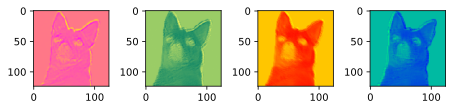

In [7]:
S = torch.stack(components).unsqueeze(0)
cmaps_out = ['spring', 'summer', 'autumn', 'winter']

print("Input shape: ", X.shape)   # (B, c0, H0, W0)
print("Output shape:", S.shape)   # (B, c1, H1, W1)
print("Kernel shape:", K.shape)   # (c1, c0, h, w)
print("Bias shape:  ", u.shape)   # (c1,)

# Check if above formula agrees with PyTorch implementation
print("MAE (w/ pytorch) =", (S - conv(X)).abs().mean().item())

# Plotting the images obtained using the above formula
print("\nOutput components (from scratch):")
fig, ax = plt.subplots(1, 4)
for k in range(4):
    ax[k].imshow(S[0, k].detach().numpy(), cmaps_out[k])
fig.tight_layout()

### Padding and stride

**Stride.** The step size of the kernel can be controlled using the stride parameter. A large stride along with a large kernel size can be useful if objects are large relative to the dimension of the image. Note that stride significantly reduces computation by constant factor. Strided convolutions have been used as an alternative way to downsample an image (i.e. works better or just as well as conv + pooling) {cite}`allconv`. Notice that the spatial size decreases with stride:

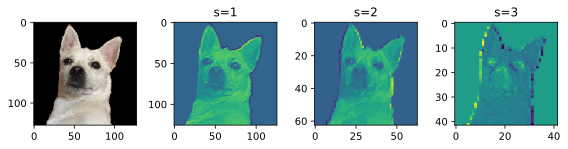

In [8]:
conv = lambda s: nn.Conv2d(in_channels=3, out_channels=3, stride=s, kernel_size=3)
fig, ax = plt.subplots(1, 4, figsize=(8, 2))

ax[0].imshow(X[0].permute(1, 2, 0))
ax[1].imshow(conv(1)(X)[0, 0].detach().numpy()); ax[1].set_title("s=1")
ax[2].imshow(conv(2)(X)[0, 0].detach().numpy()); ax[2].set_title("s=2")
ax[3].imshow(conv(3)(X)[0, 0].detach().numpy()); ax[3].set_title("s=3")
fig.tight_layout();

<br>

**Zero padding.** Note that central pixels are overrepresented since the kernels have to be kept within the input image. Information on the boundaries of the input become lost as we stack more convolutional layers. A simple solution is to zero pad the boundaries. Observe the weird effect on the boundaries:

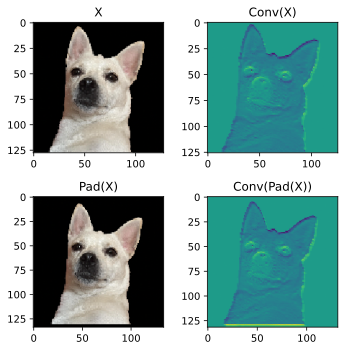

In [9]:
pad  = nn.ZeroPad2d(padding=3)
conv = nn.Conv2d(3, 1, kernel_size=3)

fig, ax = plt.subplots(2, 2, figsize=(5, 5))
vmin = min(conv(X).min(), conv(pad(X)).min())
vmax = max(conv(X).max(), conv(pad(X)).max())
ax[1, 0].imshow(pad(X)[0].permute(1, 2, 0).detach(), vmin=vmin, vmax=vmax); ax[1, 0].set_title("Pad(X)")
ax[1, 1].imshow(conv(pad(X))[0, 0].detach(),         vmin=vmin, vmax=vmax); ax[1, 1].set_title("Conv(Pad(X))")
ax[0, 0].imshow(X[0].permute(1, 2, 0).detach(),      vmin=vmin, vmax=vmax); ax[0, 0].set_title("X")
ax[0, 1].imshow(conv(X)[0, 0].detach(),              vmin=vmin, vmax=vmax); ax[0, 1].set_title("Conv(X)")
fig.tight_layout();

<br>

**Remark.** Padding and stride determines the spatial dimensions of the output feature maps. An input of width $w$ and equal padding $p$, and kernel size $k$ with stride $s$ has an output of width $\lfloor(w + 2p - k)/s + 1\rfloor$. In particular, we have to carefully choose stride and padding values so that the kernel can be placed evenly in the image so that no input pixel is dropped.

For ${s} = 1,$ kernel size should be odd so that it covers the entire input in a symmetric manner. A common choice is $p = (k - 1)/2$ which results in same sized outputs (i.e. the so-called **same convolution**). For ${s} > 1,$ the best practice is to choose a kernel size and the smallest $p$ such that $s$ divides $w + 2p - k$ so that the entire input image is symmetrically covered by the kernel.

### Pooling

Pooling layers downsample an input by performing nonparametric operations that slides across the input like convolutional layers. Pooling is applied to each channel separately, so that the number of output channels is maintained. This makes sense since we want only to compress the original input without affecting its semantic structure.

```{margin}
Figure from: <br>
[`cs231n/conv-nets`](https://cs231n.github.io/convolutional-networks/)
```
```{figure} ../../img/pooling-cs231n.png
---
width: 300px

---

Pooling layer downsamples the volume spatially independently in each channel. The input tensor of size 224 × 224 × 64 is pooled with filter size 2 and stride 2 into output volume of size 112 × 112 × 64.
```

**Max pooling**. A max pooling layer makes the network insensitive to small noise or fine-grained details in the input at the cost of some information loss. It can be interpreted as a form of competition between neurons since the gradient only flows through the activated neuron. A soft alternative is **average pooling**.

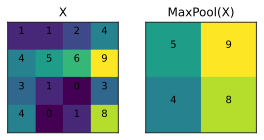

In [10]:
x = torch.tensor([
    [ 1, 1, 2, 4],
    [ 4, 5, 6, 9],
    [ 3, 1, 0, 3],
    [ 4, 0, 1, 8]]
)[None, None, :, :].float()

pool = nn.MaxPool2d(kernel_size=2, stride=2)

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(4, 2))
ax[0].set_title("X")
ax[0].imshow(x.numpy()[0, 0, :, :], cmap='viridis', vmin=0)
ax[0].set_xticks([])
ax[0].set_yticks([])
for i in range(4):
    for j in range(4):
        ax[0].text(j, i, int(x[0, 0, i, j].numpy()), ha="center", va="bottom", color='black')

ax[1].set_title("MaxPool(X)")
ax[1].imshow(pool(x)[0].detach().permute(1, 2, 0), cmap='viridis', vmin=0)
ax[1].set_xticks([])
ax[1].set_yticks([])
for i in range(2):
    for j in range(2):
        ax[1].text(j, i, int(pool(x)[0, 0, i, j].numpy()), ha="center", va="bottom", color='black')

fig.tight_layout()

Commonly used settings for max pooling are $k = 2, s = 2$ where the pooling regions do not overlap, and $k = 3, s = 2$ where some overlap is allowed. Using a large kernel relative to the input may result in the loss of discriminative information:

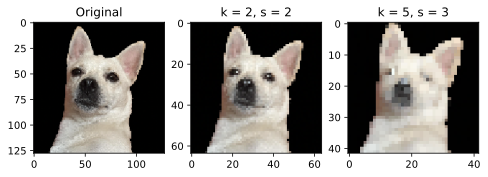

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(8, 3))
ax[0].imshow(X[0, :, :, :].permute(1, 2, 0))
ax[0].set_title("Original")
ax[1].imshow(nn.MaxPool2d(kernel_size=2, stride=2)(X)[0, :, :, :].permute(1, 2, 0))
ax[1].set_title("k = 2, s = 2")
ax[2].imshow(nn.MaxPool2d(kernel_size=5, stride=3)(X)[0, :, :, :].permute(1, 2, 0))
ax[2].set_title("k = 5, s = 3");

**Remark.** Pooling exponentially increases the **receptive field** of a unit ({numref}`receptive_field`). The receptive field of a unit consists of all units from previous layers that influences its value during forward pass. In particular, units for each class in the softmax layer should have a receptive field that includes the entire input. Otherwise, some parts of the input will not affect the prediction of the model for that class. 

<br>

```{margin}
Fig 14.2 in {cite}`geron2019hands-on`
```
```{figure} ../../img/receptive_field.png
---
name: receptive_field
width: 28em
---
Receptive field of a pixel in a convolutional network. For an output pixel in an intermediate layer, whose are inputs are formed from stacked convolutions, its larger receptive field indicates that it processes hierarchical features of the original image.
```

**Global pooling**. Global pooling follows that intuition that we want to detect some patterns, but we do not care too much where exactly these patterns are ({numref}`03-pooling-text`). A **global average pooling** (GAP) layer will also be used later for an image classification task allowing the network to learn one feature detector for each output channel.

```{figure} ../../img/nn/03-pooling-text.png
---
width: 740px
name: 03-pooling-text
---

A typical convolutional model for texts consist of conv + pooling blocks. Here convolutions are applicable when we want to classify text using the presence of local features (e.g. certain phrases). [Source](https://lena-voita.github.io/nlp_course/models/convolutional.html)
```

## Training engine

To separate concerns during model training, we define a **trainer engine**. For example, this defines an `eval_context` to automatically set the model to eval mode at entry, and back to the default train mode at exit. This is useful for layers such as BN and Dropout which have different behaviors at train and test times. LR schedulers and callbacks are also implemented. Currently, these are called at the end of each training step (it is easy to extend this class to implement epoch end callbacks).

In [12]:
from tqdm.notebook import tqdm
from contextlib import contextmanager
from torch.utils.data import DataLoader


@contextmanager
def eval_context(model):
    """Temporarily set to eval mode inside context."""
    state = model.training
    model.eval()
    try:
        yield
    finally:
        model.train(state)


class Trainer:
    def __init__(self,
        model, optim, loss_fn, scheduler=None, callbacks=[],
        device=DEVICE, verbose=True
    ):
        self.model = model.to(device)
        self.optim = optim
        self.device = device
        self.loss_fn = loss_fn
        self.train_log = {'loss': [], 'accs': [], 'loss_avg': [], 'accs_avg': []}
        self.valid_log = {'loss': [], 'accs': []}
        self.verbose = verbose
        self.scheduler = scheduler
        self.callbacks = callbacks
    
    def __call__(self, x):
        return self.model(x.to(self.device))

    def forward(self, batch):
        x, y = batch
        x = x.to(self.device)
        y = y.to(self.device)
        return self.model(x), y

    def train_step(self, batch):
        preds, y = self.forward(batch)
        accs = (preds.argmax(dim=1) == y).float().mean()
        loss = self.loss_fn(preds, y)
        loss.backward()
        self.optim.step()
        self.optim.zero_grad()
        return {'loss': loss, 'accs': accs}

    @torch.inference_mode()
    def valid_step(self, batch):
        preds, y = self.forward(batch)
        accs = (preds.argmax(dim=1) == y).float().sum()
        loss = self.loss_fn(preds, y, reduction='sum')
        return {'loss': loss, 'accs': accs}
    
    def run(self, epochs, train_loader, valid_loader, window_size=None):
        steps_per_epoch = len(train_loader)
        if not window_size:
            window_size = int(0.05 * steps_per_epoch)

        for e in tqdm(range(epochs)):
            for i, batch in enumerate(train_loader):
                # optim and lr step
                output = self.train_step(batch)
                if self.scheduler:
                    self.scheduler.step()

                # step callbacks
                for callback in self.callbacks:
                    callback()

                # logs @ train step
                self.train_log['loss'].append(output['loss'].item())
                self.train_log['accs'].append(output['accs'].item())
                self.train_log['loss_avg'].append(np.mean(self.train_log['loss'][-window_size:]))
                self.train_log['accs_avg'].append(np.mean(self.train_log['accs'][-window_size:]))

            # logs @ epoch
            output = self.evaluate(valid_loader)
            self.valid_log['loss'].append(output['loss'])
            self.valid_log['accs'].append(output['accs'])
            if self.verbose:
                print(f"[Epoch: {e+1:>0{int(len(str(epochs)))}d}/{epochs}]    loss: {self.train_log['loss_avg'][-1]:.4f}  acc: {self.train_log['accs_avg'][-1]:.4f}    val_loss: {self.valid_log['loss'][-1]:.4f}  val_acc: {self.valid_log['accs'][-1]:.4f}")

    def evaluate(self, data_loader):
        with eval_context(self.model):
            valid_loss = 0.0
            valid_accs = 0.0
            for batch in data_loader:
                output = self.valid_step(batch)
                valid_loss += output['loss'].item()
                valid_accs += output['accs'].item()

        return {
            'loss': valid_loss / len(data_loader.dataset),
            'accs': valid_accs / len(data_loader.dataset)
        }

    @torch.inference_mode()
    def predict(self, x: torch.Tensor):
        with eval_context(self.model):
            return self(x)

    @torch.inference_mode()
    def batch_predict(self, input_loader: DataLoader):
        with eval_context(self.model):
            preds = [self(x) for x in input_loader]
            preds = torch.cat(preds, dim=0)
        return preds

The `predict` method is suited for inference over *one* transformed mini-batch. A model call over a large input tensor may cause memory error. The model does not generate a computational graph to conserve memory and calls the model with layers in eval mode. For large batches, one should use `batch_predict` which is the same but takes in a data loader with transforms.

In [13]:
model = nn.Sequential(nn.Linear(3, 10), nn.Dropout(1.0))
trainer = Trainer(model, optim=None, scheduler=None, loss_fn=None)

# inference mode using eval_context
x = torch.ones(size=(1, 3), requires_grad=True)
print(f"__call__    {(trainer(x) > 0).float().mean():.3f}")
print(f"predict     {(trainer.predict(x) > 0).float().mean():.3f}")

__call__    0.000
predict     0.400


Checking computational graph generation:

In [14]:
y = trainer(x)
z = trainer.predict(x)
print('__call__   ', y.requires_grad)
print('predict    ', z.requires_grad)

__call__    True
predict     False


## Convolutional networks

In this section, we will implement **LeNet** {cite}`lenet` to classify MNIST digits. This network is characterized as having conv + pool blocks as feature extractor. The feature representations are then passed to a fully-connected subnetwork ending with 10 nodes for each class label. The network downsamples the spatial dimensions, but increases the number of output channels so that network capacity is not diminished.

```{figure} https://www.d2l.ai/_images/lenet.svg
---
name: lenet
---
Network architecture. [Source](https://www.d2l.ai/chapter_convolutional-neural-networks/lenet.html)
```

**Remark.** A **block** is composed of multiple layers that together form a basic functional unit. This is generally used in designing neural net architectures. See also **AlexNet** {cite}`alexnet` and **VGG** {cite}`vgg` which takes this network design to the extreme ({numref}`03-alexnet-vgg`). These network have blocks that contain consecutive convolutional layers.

### Model

In [15]:
import torchsummary

mnist_model = lambda: nn.Sequential(
    nn.Conv2d(1, 32, kernel_size=3, padding=1),
    nn.SELU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    
    nn.Conv2d(32, 32, kernel_size=5, padding=0),
    nn.SELU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    
    nn.Flatten(),
    nn.Linear(32 * 5 * 5, 256),
    nn.SELU(),
    nn.Dropout(0.5),
    nn.Linear(256, 10)
)

torchsummary.summary(mnist_model(), (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
              SELU-2           [-1, 32, 28, 28]               0
         MaxPool2d-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 32, 10, 10]          25,632
              SELU-5           [-1, 32, 10, 10]               0
         MaxPool2d-6             [-1, 32, 5, 5]               0
           Flatten-7                  [-1, 800]               0
            Linear-8                  [-1, 256]         205,056
              SELU-9                  [-1, 256]               0
          Dropout-10                  [-1, 256]               0
           Linear-11                   [-1, 10]           2,570
Total params: 233,578
Trainable params: 233,578
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

**Remark.** We use **SELU activation** {cite}`selu` for fun. Note that we also used **Dropout** {cite}`dropout` as regularization for the dense layers. These will be discussed in a future notebook in this series. Observe that convolutions have small contribution to the total number of parameters of the network!

<br>

```{figure} ../../img/nn/03-alexnet-vgg.png
---
name: 03-alexnet-vgg
---
Network architecture of AlexNet and VGG. More layers means more processing, which is
why we see repeated convolutions and blocks. [Source](https://www.d2l.ai/chapter_convolutional-modern/vgg.html#vgg-network)
```

Setting up MNIST data loaders:

In [16]:
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import random_split, DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x / 255.)
])

mnist_all = MNIST(root=DATASET_DIR, download=True, transform=transform)
mnist_train, mnist_valid = random_split(
    mnist_all, [55000, 5000], 
    generator=torch.Generator().manual_seed(RANDOM_SEED)
)

mnist_train_loader = DataLoader(mnist_train, batch_size=32, shuffle=True) # (!)
mnist_valid_loader = DataLoader(mnist_valid, batch_size=32, shuffle=False)

**Remark.** `shuffle=True` is important for SGD training. The model has low validation score when looping through the samples in the same order during training. This may be due to cyclic behavior in the updates (i.e. they cancel out).

### LR scheduling

Training the model with [one-cycle LR](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.OneCycleLR.html) schedule {cite}`super-convergence-resnet`. The one-cycle policy anneals the learning rate from an initial learning rate to some maximum learning rate and then from that maximum learning rate to some minimum learning rate much lower than the initial learning rate. Momentum is also annealed inversely to the learning rate which is necessary for stability.

In [17]:
from torch.optim.lr_scheduler import OneCycleLR

class SchedulerStatsCallback:
    def __init__(self, optim):
        self.lr = []
        self.momentum = []
        self.optim = optim

    def __call__(self):
        self.lr.append(self.optim.param_groups[0]["lr"])
        self.momentum.append(self.optim.param_groups[0]["betas"][0])

epochs = 3
model = mnist_model().to(DEVICE)
loss_fn = F.cross_entropy
optim = torch.optim.AdamW(model.parameters(), lr=0.001)
scheduler = OneCycleLR(optim, max_lr=0.01, steps_per_epoch=len(mnist_train_loader), epochs=epochs)
scheduler_stats = SchedulerStatsCallback(optim)
trainer = Trainer(model, optim, loss_fn, scheduler, callbacks=[scheduler_stats])
trainer.run(epochs=epochs, train_loader=mnist_train_loader, valid_loader=mnist_valid_loader)

  0%|          | 0/3 [00:00<?, ?it/s]

[Epoch: 1/3]    loss: 2.4117  acc: 0.8376    val_loss: 0.7138  val_acc: 0.9424
[Epoch: 2/3]    loss: 0.3904  acc: 0.9458    val_loss: 0.1911  val_acc: 0.9732
[Epoch: 3/3]    loss: 0.1287  acc: 0.9743    val_loss: 0.0996  val_acc: 0.9804


**Remark.** After trying out other activations... SELU performance is surprising. It also trains really fast. That self-normalizing bit is no joke.

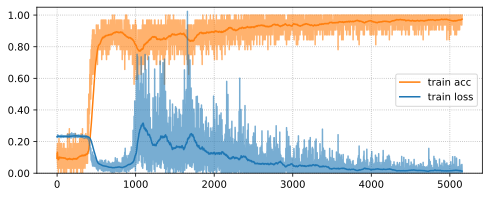

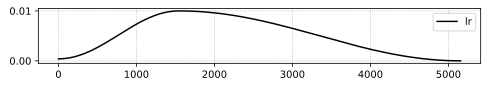

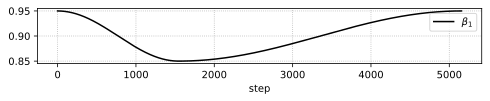

In [18]:
from matplotlib.ticker import StrMethodFormatter

plt.figure(figsize=(8, 3))
plt.gca().yaxis.set_major_formatter(StrMethodFormatter("{x:,.2f}")) # 2 decimal places
plt.plot(np.array(trainer.train_log["accs"]), alpha=0.6, color="C1")
plt.plot(np.array(trainer.train_log["accs_avg"]), color="C1", label="train acc")
plt.plot(np.array(trainer.train_log["loss"]) / 10, alpha=0.6, color="C0")
plt.plot(np.array(trainer.train_log["loss_avg"]) / 10, color="C0", label="train loss")
plt.grid(linestyle="dotted")
plt.ylim(0.00, 1.05)
plt.legend();

plt.figure(figsize=(8, 1))
plt.plot(scheduler_stats.lr, color="black", label="lr")
plt.grid(linestyle="dotted")
plt.legend();

plt.figure(figsize=(8, 1))
plt.xlabel("step")
plt.plot(scheduler_stats.momentum, color="black", label=r"$\beta_1$")
plt.grid(linestyle="dotted")
plt.legend();

**Figure.** Note peak in train loss as LR increases to `max_lr` set at initialization, and the decreasing noise as the LR decreases at the end of training.
This works similarly with the **LR finder** which is a parameter-free method 
described in a [previous notebook](dl/02-optim) for finding a good value for `lr` (i.e. the base LR).
Although in this case, the bump in LR occurs over a wide duration during training, 
so that the optimizer avoids many sharp minima. 
This allows the network to train with less epochs &mdash; increasing the number of 
epochs increases the exploration time (not just convergence time).

### Feature maps

Showing intermediate activations. Recall that feature map in the input of a convolutional layer is used to create each output feature map. Max-pooling and SELU on the other hand acts on each feature map independently. Note that fully-connected layer outputs are reshaped to two dimensions for the sake of presentation.

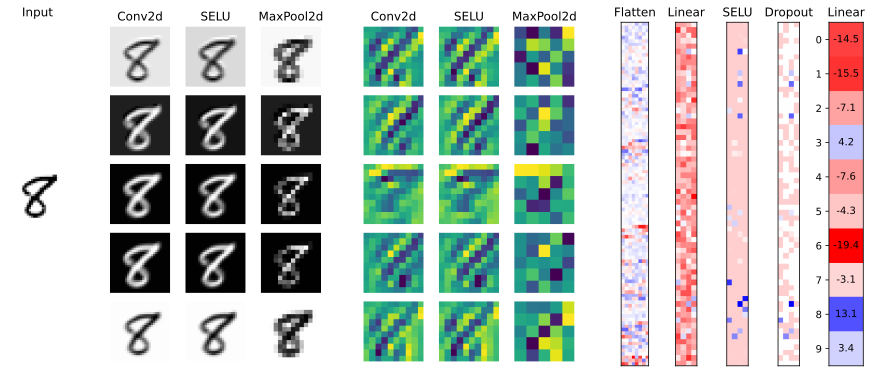

In [19]:
from matplotlib.colors import LinearSegmentedColormap

x, y = next(iter(mnist_valid_loader))
b = torch.argmax((y == 8).type(torch.int64))
x = x[b:b+1, :].to(DEVICE) # first element

width_ratios = [1, 0.2, 1, 1, 1, 0.2, 1, 1, 1, 0.2, 0.6, 0.6, 0.6, 0.6, 0.8]
fig = plt.figure(figsize=(12, 5), constrained_layout=True)
spec = fig.add_gridspec(5, len(width_ratios), width_ratios=width_ratios)
cmap = LinearSegmentedColormap.from_list('custom', ['red', 'white', 'blue'])

# Input image
input_layer = []
for i in range(5):
    input_layer.append(fig.add_subplot(spec[i, 0]))
    input_layer[i].set_axis_off()

input_layer[2].imshow(x[0, 0].cpu().detach().numpy(), cmap="Greys")
input_layer[0].set_title("Input")

# Block 1
for k in range(3):
    x = model[k](x)
    layer = []
    for i in range(5):
        layer.append(fig.add_subplot(spec[i, k + 2]))
        layer[i].set_axis_off()
        layer[i].imshow(x[0, i+10].cpu().detach().numpy(), cmap="Greys")
        layer[i].axis("off")
    layer[0].set_title(type(model[k]).__name__)

# Block 2
for k in range(3):
    x = model[3 + k](x)
    layer = []
    for i in range(5):
        layer.append(fig.add_subplot(spec[i, k + 6]))
        layer[i].set_axis_off()
        layer[i].imshow(x[0, i].cpu().detach().numpy())
        layer[i].axis("off")
    layer[0].set_title(type(model[k]).__name__)

# Classification subnetwork
for l in range(5):
    x = model[6 + l](x)
    if l == 0:
        data = x[0].cpu().detach().view(-1, 8).numpy()
    elif l < 4:
        data = x[0].cpu().detach().view(-1, 4).numpy()
    else:
        data = x[0].cpu().detach().view(-1, 1).numpy()

    a = np.abs(data).max()
    ax = fig.add_subplot(spec[:, 10 + l])
    ax.imshow(data, cmap=cmap, vmin=-a, vmax=a)
    ax.xaxis.set_visible(False)
    ax.set_title(type(model[6 + l]).__name__)
    ax.tick_params(axis="y", colors="white")


# For last layer annotate value
for i in range(10):
    ax.tick_params(axis="y", colors="black")
    ax.set_yticks(range(10))
    ax.text(0, i, f"{data[i, 0]:.1f}", ha="center", va="center", color='black')
    
fig.tight_layout(pad=0.00)

Model predict probability (increase [temperature](https://stats.stackexchange.com/a/527082) to make the distribution look more random):

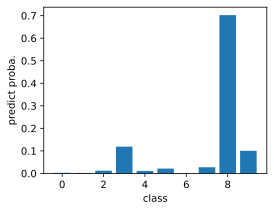

In [20]:
temp = 5.0
plt.figure(figsize=(4, 3))
plt.bar(range(10), F.softmax(x / temp, dim=1).detach().cpu()[0])
plt.xlabel("class")
plt.ylabel("predict proba.");

## Data augmentation

MNIST is not representative of real-world datasets. Below we continue with the [Histopathologic Cancer Detection](https://www.kaggle.com/competitions/histopathologic-cancer-detection/data) dataset from Kaggle. 
The competition task is to detect metastatic cancer in patches of images from digital pathology scans.
Download the dataset such that the folder structure looks like:

In [21]:
!tree -L 1 ./data/histopathologic-cancer-detection

./data/histopathologic-cancer-detection
├── test
├── train
└── train_labels.csv

3 directories, 1 file


Taking a look at the first few images:

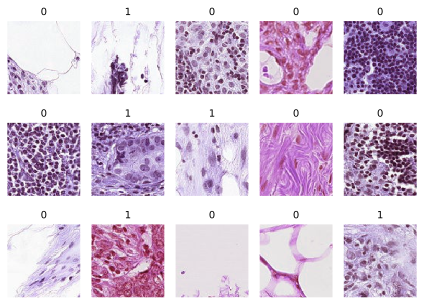

In [22]:
import cv2

IMG_DATASET_DIR = DATASET_DIR / "histopathologic-cancer-detection"
data = pd.read_csv(IMG_DATASET_DIR / "train_labels.csv")
fig, ax = plt.subplots(3, 5, figsize=(6, 4.5))

for k in range(15):
    i, j = divmod(k, 5)
    fname = str(IMG_DATASET_DIR / "train" / f"{data.id[k]}.tif")
    ax[i, j].imshow(cv2.imread(fname))
    ax[i, j].set_title(data.label[k], size=10)
    ax[i, j].axis("off")

fig.tight_layout()

A positive label indicates that the center 32 × 32 region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label.
This outer region is provided to enable fully-convolutional models that do not use zero-padding, to ensure consistent behavior when applied to a whole-slide image.

### Stochastic transforms

Data augmentation incorporates transformed or perturbed versions of the original images into the dataset. More precisely, each data point
$(\boldsymbol{\mathsf{x}}, y)$ in a mini-batch is replaced by $(T(\boldsymbol{\mathsf{x}}), y)$ during training
where $T$ is a stochastic label preserving transformation. At inference, an input $\boldsymbol{\mathsf{x}}$ is replaced by $\mathbb{E}[T(\boldsymbol{\mathsf{x}})].$

In [23]:
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.CenterCrop([49, 49]),
])

transform_infer = transforms.Compose([
    transforms.ToTensor(),
    transforms.CenterCrop([49, 49]),
])

Recall that only the central pixels contribute to the labels. This motivates using center crop. Furthermore, we know that tissue samples in the slides can be flipped horizontally and vertically, as well as rotated (set to $\pm 20^{\circ}$ above) without affecting the actual presence of tumor tissue.

In [24]:
from torch.utils.data import DataLoader, Dataset, Subset

class HistopathologicDataset(Dataset):
    def __init__(self, data, train=True, transform=None):
        split = "train" if train else "test"
        self.fnames = [str(IMG_DATASET_DIR / split / f"{fn}.tif") for fn in data.id]
        self.labels = data.label.tolist()
        self.transform = transform
    
    def __len__(self):
        return len(self.fnames)
    
    def __getitem__(self, index):
        img = cv2.imread(self.fnames[index])
        if self.transform:
            img = self.transform(img)
        
        return img, self.labels[index]


data = data.sample(frac=1.0)
split = int(0.80 * len(data))
histo_train_dataset = HistopathologicDataset(data[:split], train=True, transform=transform_train)
histo_valid_dataset = HistopathologicDataset(data[split:], train=True, transform=transform_infer)

Some imbalance (not too severe):

In [25]:
# percentage of positive class
data[:split].label.mean(), data[split:].label.mean()

(0.4050562436086808, 0.4049312578116123)

Simulating images across epochs:

In [26]:
simul_train = DataLoader(Subset(histo_train_dataset, torch.arange(3)), batch_size=3, shuffle=True)
simul_valid = DataLoader(Subset(histo_valid_dataset, torch.arange(1)), batch_size=1, shuffle=False)

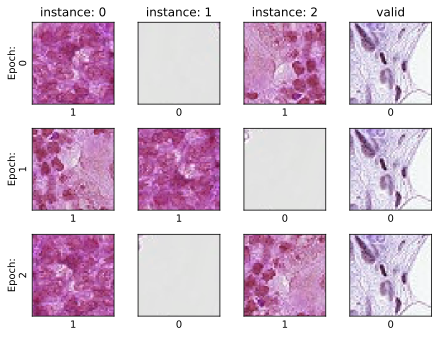

In [27]:
fig, ax = plt.subplots(3, 4)
for e in range(3):
    img_train, tgt_train = next(iter(simul_train))
    for i in range(3):
        if i == 0:
            ax[e, i].set_ylabel(f"Epoch:\n{e}")
        
        img, tgt = img_train[i], tgt_train[i]
        ax[e, i].imshow(img.permute(1, 2, 0).detach())
        ax[e, i].set_xlabel(tgt.item())
        ax[e, i].set_xticks([])
        ax[e, i].set_yticks([])
        ax[0, i].set_title(f"instance: {i}")

    img_valid, tgt_valid = next(iter(simul_valid))
    ax[e, 3].set_xlabel(tgt_valid[0].item())
    ax[e, 3].imshow(img_valid[0].permute(1, 2, 0).detach())
    ax[e, 3].set_xticks([])
    ax[e, 3].set_yticks([])

ax[0, 3].set_title('valid')
fig.tight_layout()

**Figure.** Inputs are stochastically transformed at each epoch. Note that the labels are not affected (both at the recognition and implementation level). The test and validation sets have fixed transformations implementing the expectation of the random transformations.

## Transfer learning

Transfer learning is a common technique for leveraging large models trained on related tasks (i.e. the so-called **pretrained model**). Here we will use ResNet {cite}`resnet` trained on [ImageNet](https://image-net.org/) which consists of millions of images in 1000 object categories. This requires us to replace the **classification head** which is task specific, and retain the feature extractors.

To not destroy the pretrained weights, we first train the classification head to convergence while keeping the weights of the pretrained model fixed. Then, we will proceed to **fine-tune** the pretrained weights with a low learning rate, again so that the pretrained weights are gradually changed.

In [28]:
import torchinfo
from torchvision import models

resnet = models.resnet18(pretrained=True)

BATCH_SIZE = 16
torchinfo.summary(resnet, input_size=(BATCH_SIZE, 3, 49, 49))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [16, 1000]                --
├─Conv2d: 1-1                            [16, 64, 25, 25]          9,408
├─BatchNorm2d: 1-2                       [16, 64, 25, 25]          128
├─ReLU: 1-3                              [16, 64, 25, 25]          --
├─MaxPool2d: 1-4                         [16, 64, 13, 13]          --
├─Sequential: 1-5                        [16, 64, 13, 13]          --
│    └─BasicBlock: 2-1                   [16, 64, 13, 13]          --
│    │    └─Conv2d: 3-1                  [16, 64, 13, 13]          36,864
│    │    └─BatchNorm2d: 3-2             [16, 64, 13, 13]          128
│    │    └─ReLU: 3-3                    [16, 64, 13, 13]          --
│    │    └─Conv2d: 3-4                  [16, 64, 13, 13]          36,864
│    │    └─BatchNorm2d: 3-5             [16, 64, 13, 13]          128
│    │    └─ReLU: 3-6                    [16, 64, 13, 13]          --
│

In [29]:
in_features = resnet.fc.in_features
num_hidden = 256

head = nn.Sequential(
    nn.AdaptiveAvgPool2d(1),
    nn.Flatten(),
    nn.BatchNorm1d(in_features),
    nn.Dropout(0.5),
    nn.Linear(in_features, num_hidden),
    nn.ReLU(),
    nn.BatchNorm1d(num_hidden),
    nn.Dropout(0.5),
    nn.Linear(num_hidden, 2),
)

model = nn.Sequential(
    nn.Sequential(*list(resnet.children())[:-2]),
    head
)

**Remark.** This network is fairly deep, so we use **batch normalization** (BN) {cite}`batchnorm` to aid with activation and gradient stability. BN is discussed in more detail in a future notebook. Dropout is also used to regularize the dense layers.

### Static features

Freeze feature extraction layers:

In [30]:
for param in model[0].parameters():
    param.requires_grad = False

Setting up the data loaders:

In [31]:
histo_train_loader = DataLoader(Subset(histo_train_dataset, torch.arange(32000)), batch_size=BATCH_SIZE, shuffle=True)
histo_valid_loader = DataLoader(Subset(histo_valid_dataset, torch.arange(8000)),  batch_size=BATCH_SIZE, shuffle=False)

Training the model using AdamW {cite}`adamw` with a learning rate of `0.001` and a batch size of 8:

In [32]:
epochs = 10
optim = torch.optim.AdamW(model.parameters(), lr=0.001)
scheduler = OneCycleLR(optim, max_lr=0.01, steps_per_epoch=len(histo_train_loader), epochs=epochs)
trainer = Trainer(model, optim, loss_fn=F.cross_entropy, scheduler=scheduler, device=DEVICE)
trainer.run(epochs=epochs, train_loader=histo_train_loader, valid_loader=histo_valid_loader)

  0%|          | 0/10 [00:00<?, ?it/s]

[Epoch: 01/10]    loss: 0.6116  acc: 0.6813    val_loss: 0.5469  val_acc: 0.7498
[Epoch: 02/10]    loss: 0.5852  acc: 0.6875    val_loss: 0.5085  val_acc: 0.7602
[Epoch: 03/10]    loss: 0.5881  acc: 0.6931    val_loss: 0.5313  val_acc: 0.7444
[Epoch: 04/10]    loss: 0.5583  acc: 0.7131    val_loss: 0.5050  val_acc: 0.7644
[Epoch: 05/10]    loss: 0.5872  acc: 0.6906    val_loss: 0.5269  val_acc: 0.7401
[Epoch: 06/10]    loss: 0.5675  acc: 0.7019    val_loss: 0.5112  val_acc: 0.7545
[Epoch: 07/10]    loss: 0.5578  acc: 0.6994    val_loss: 0.5047  val_acc: 0.7734
[Epoch: 08/10]    loss: 0.5598  acc: 0.7125    val_loss: 0.4873  val_acc: 0.7752
[Epoch: 09/10]    loss: 0.5287  acc: 0.7331    val_loss: 0.4830  val_acc: 0.7705
[Epoch: 10/10]    loss: 0.5342  acc: 0.7412    val_loss: 0.4811  val_acc: 0.7770


In [33]:
def plot_training_history(trainer):
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    num_epochs = len(trainer.valid_log['accs'])
    num_steps_per_epoch = len(trainer.train_log['accs']) // num_epochs
    ax[0].plot(trainer.train_log['loss'], alpha=0.3, color="C0")
    ax[1].plot(trainer.train_log['accs'], alpha=0.3, color="C0")
    ax[0].plot(trainer.train_log['loss_avg'], label='train', color="C0")
    ax[1].plot(trainer.train_log['accs_avg'], label='train', color="C0")
    ax[0].plot(list(range(num_steps_per_epoch, (num_epochs + 1) * num_steps_per_epoch, num_steps_per_epoch)), trainer.valid_log['loss'], label='valid', color="C1")
    ax[1].plot(list(range(num_steps_per_epoch, (num_epochs + 1) * num_steps_per_epoch, num_steps_per_epoch)), trainer.valid_log['accs'], label='valid', color="C1")
    ax[0].set_xlabel('step')
    ax[0].set_ylabel('loss')
    ax[0].grid(linestyle='dashed', alpha=0.3)
    ax[1].set_xlabel('step')
    ax[1].set_ylabel('accuracy')
    ax[1].grid(linestyle='dashed', alpha=0.3)
    ax[1].legend()
    ax[0].set_ylim(0, max(trainer.train_log["loss"]))
    ax[1].set_ylim(0, 1)
    ax[0].ticklabel_format(axis="x", style="sci", scilimits=(3, 3))
    ax[1].ticklabel_format(axis="x", style="sci", scilimits=(3, 3))
    
    fig.tight_layout();

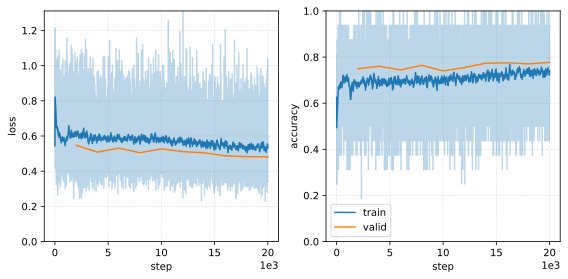

In [34]:
plot_training_history(trainer)

**Remark.** The validation step accumulates results over after an epoch for a fixed set of weights. This simulates inference performance if we load the trained model at that **checkpoint**. On the other hand, train metrics are expensive since the training dataset is large. Instead, these are accumulated at each step as an average with the previous steps.

### Fine-tuning

Unfreezing the pretrained model layers. Note that we set smaller learning rates since we
don't want to destroy the pretrained weights.

In [35]:
for param in model[0].parameters():
    param.requires_grad = True

# 10X smaller lr (both optim and scheduler!)
epochs = 20
optim = torch.optim.AdamW(model.parameters(), lr=0.0001)
scheduler = OneCycleLR(optim, max_lr=0.001, steps_per_epoch=len(histo_train_loader), epochs=epochs)
trainer_ft = Trainer(model, optim, loss_fn=F.cross_entropy, scheduler=scheduler, device=DEVICE)
trainer_ft.run(epochs=epochs, train_loader=histo_train_loader, valid_loader=histo_valid_loader)

  0%|          | 0/20 [00:00<?, ?it/s]

[Epoch: 01/20]    loss: 0.3922  acc: 0.8263    val_loss: 0.3620  val_acc: 0.8510
[Epoch: 02/20]    loss: 0.3706  acc: 0.8313    val_loss: 0.3559  val_acc: 0.8514
[Epoch: 03/20]    loss: 0.3960  acc: 0.8213    val_loss: 0.3648  val_acc: 0.8558
[Epoch: 04/20]    loss: 0.4077  acc: 0.8263    val_loss: 0.4948  val_acc: 0.7358
[Epoch: 05/20]    loss: 0.3959  acc: 0.8306    val_loss: 0.5383  val_acc: 0.7649
[Epoch: 06/20]    loss: 0.4058  acc: 0.8244    val_loss: 0.3790  val_acc: 0.8374
[Epoch: 07/20]    loss: 0.3623  acc: 0.8462    val_loss: 0.3579  val_acc: 0.8439
[Epoch: 08/20]    loss: 0.3612  acc: 0.8550    val_loss: 0.3541  val_acc: 0.8572
[Epoch: 09/20]    loss: 0.3883  acc: 0.8369    val_loss: 0.3850  val_acc: 0.8289
[Epoch: 10/20]    loss: 0.3468  acc: 0.8519    val_loss: 0.4987  val_acc: 0.7555
[Epoch: 11/20]    loss: 0.3180  acc: 0.8744    val_loss: 0.3793  val_acc: 0.8374
[Epoch: 12/20]    loss: 0.3591  acc: 0.8406    val_loss: 0.3458  val_acc: 0.8551
[Epoch: 13/20]    loss: 0.32

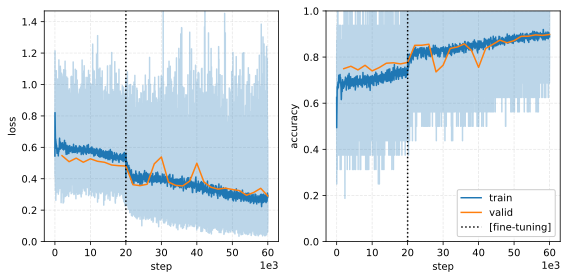

In [36]:
loss = trainer.train_log['loss'] + trainer_ft.train_log['loss']
accs = trainer.train_log['accs'] + trainer_ft.train_log['accs']
loss_avg = trainer.train_log['loss_avg'] + trainer_ft.train_log['loss_avg']
accs_avg = trainer.train_log['accs_avg'] + trainer_ft.train_log['accs_avg']
val_loss = trainer.valid_log['loss'] + trainer_ft.valid_log['loss']
val_accs = trainer.valid_log['accs'] + trainer_ft.valid_log['accs']
num_epochs = len(val_loss)
num_steps_per_epoch = len(loss) // num_epochs

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].plot(loss, alpha=0.3, color="C0")
ax[1].plot(accs, alpha=0.3, color="C0")
ax[0].plot(loss_avg, label='train', color="C0")
ax[1].plot(accs_avg, label='train', color="C0")
ax[0].plot(list(range(num_steps_per_epoch, (num_epochs + 1) * num_steps_per_epoch, num_steps_per_epoch)), val_loss, label='valid', color="C1")
ax[1].plot(list(range(num_steps_per_epoch, (num_epochs + 1) * num_steps_per_epoch, num_steps_per_epoch)), val_accs, label='valid', color="C1")
ax[0].axvline(len(trainer.train_log['loss']), color='black', linestyle='dotted', label="[fine-tuning]")
ax[1].axvline(len(trainer.train_log['loss']), color='black', linestyle='dotted', label="[fine-tuning]")
ax[0].set_xlabel('step')
ax[0].set_ylabel('loss')
ax[0].grid(linestyle='dashed', alpha=0.3)
ax[0].set_ylim(0, max(loss))
ax[1].set_xlabel('step')
ax[1].set_ylabel('accuracy')
ax[1].grid(linestyle='dashed', alpha=0.3)
ax[1].set_ylim(0, 1)
ax[1].legend(framealpha=1.0)
ax[0].ticklabel_format(axis="x", style="sci", scilimits=(3, 3))
ax[1].ticklabel_format(axis="x", style="sci", scilimits=(3, 3))
fig.tight_layout();

**Figure.** First part trains the weights of the classification head steadily improving accuracy on the outputs of the frozen pretrained ResNet model. Then, we fine-tune the pretrained weights with a small learning rate resulting in substantial gains in accuracy.

<br>

**Remarks.** If we turn off data augmentation the validation curves diverge and the model overfits very early in the training (i.e. model memorizes the training data). Data augmentation prevents this by adding noise in the input. The dense layers also does not train well without BN. Recall that the data is imbalanced, so it is imperative to look at further evaluation tools such as the [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) and [PR curve](https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html).

### Inference

The trainer `batch_predict` method takes a data loader for inference. Note that simply calling the model on an input `x` may cause memory error for large models. Hence, using a data loader inference is good practice:

In [37]:
class InputDataLoader(DataLoader):
    def __init__(self, data_loader):
        self.data_loader = data_loader

    def __iter__(self):
        for batch in self.data_loader:
            yield batch[0]

pred = trainer.batch_predict(InputDataLoader(histo_valid_loader))
print(pred.shape)
print(pred)

torch.Size([8000, 2])
tensor([[-0.1262,  0.1192],
        [ 1.5944, -1.5970],
        [ 0.7204, -0.7230],
        ...,
        [ 0.6283, -0.6305],
        [-2.0935,  2.0714],
        [-1.5581,  1.5387]], device='mps:0')


This should be equal to the final validation accuracy:

In [38]:
y = torch.cat([batch[1] for batch in histo_valid_loader], dim=0)
print((pred.argmax(dim=1) == y.to(DEVICE)).float().mean().item())
print(trainer_ft.evaluate(histo_valid_loader)['accs'])
print(trainer_ft.valid_log['accs'][-1]) # or look at final valid log

0.8980000615119934
0.898
0.898


**Remark.** Recall that data points in our data loader come transformed. For processing raw images, we may have to call the eval mode transformation during model deployment as follows:

In [39]:
file_path = "data/histopathologic-cancer-detection/test/0a0a1f3867f41e02353afcaf503f63be1bdd35ec.tif"
test_data = cv2.imread(file_path)
print(trainer.predict(transform_infer(test_data).unsqueeze(0)))

tensor([[ 1.2709, -1.2744]], device='mps:0')


## Appendix: Guided Backprop

To explain the outputs of convolutional networks, we can look at the effect of each
pixel in the input on each output node corresponding to a class.
That is, we consider gradients $\partial y / {\partial \boldsymbol{\mathsf{X}}^{\ell}}_{ij}$
for a target class $y$ where $\ell = 0$ for the input image.
Note that gradients can be negative in intermediate layers, so to get a stronger signal
we mask these gradients when computing backpropagation with respect to ${\boldsymbol{\mathsf{X}}^0}_{ij}$.

In effect, we backpropagate only through those neurons which cause a first-order increase
in the target class $y$. 
Finally, positive activation indicate pattern detection for each node, hence 
we mask out nodes with negative activations further strengthening the signal.
Since this is applied to all layers, we get patterns which are compositional
and would eventually result in a positive activation for the target node.
This method is called **Guided Backpropagation** (GB) {cite}`allconv` used to get fine-grained
details in the input image.

In [40]:
def standardize_and_clip(x, min_val=0.0, max_val=1.0, saturation=0.1, brightness=0.5):
    x = x.detach().cpu()
    u = x.mean()
    v = max(x.std(), 1e-7)
    standardized = x.sub(u).div(v).mul(saturation)
    clipped = standardized.add(brightness).clamp(min_val, max_val)
    return clipped

def relu_hook_function(module, grad_in, grad_out):
    # Mask out negative gradients, and negative outputs
    # Note: ∂relu(x)/∂x = [x > 0] = [relu(x) > 0], 
    # so that ∂(relu input) = [relu(x) > 0] * ∂(relu output).
    # This explains why we take the gradient wrt relu input.
    return (torch.clamp(grad_in[0], min=0.),)

def resize(x):
    return transforms.Resize(size=(224, 224))(x)

def register_hooks(model):
    hooks = []
    for _, module in model.named_modules():
        if isinstance(module, torch.nn.ReLU):
            h = module.register_backward_hook(relu_hook_function)
            hooks.append(h)
    return hooks

def guided_backprop(model, x, target=None):
    hooks = register_hooks(model)

    # backward through target node
    with eval_context(model):
        p = model(x)
        if target is None:
            target = p.argmax().item()

        y = p[0, target]
        y.backward()

    g = standardize_and_clip(x.grad)
    
    # cleanup (gradients and hooks)
    for _, module in model.named_modules():
        module.zero_grad()

    for h in hooks:
        h.remove()

    return {
        "x": resize(x[0]),
        "g": resize(g[0]).max(dim=0)[0],    # <- max guided backprop!, 1×H×W map.
        "p": F.softmax(p, dim=1)[0, target]
    }   


# viz pathological tissue samples
outs = {}
target = 1
num_samples = 3
for b in range(num_samples):
    
    # prepare input image
    filepath = "data/histopathologic-cancer-detection/train"
    filename = data[data.label == target].iloc[b, 0]
    image = f"{filepath}/{filename}.tif"
    x = transform_infer(cv2.imread(image)).unsqueeze(0).to(DEVICE)
    x.requires_grad = True
    
    # magic happening...
    outs[b] = guided_backprop(model, x, target)

```{margin}
💡 See [this video](https://www.youtube.com/watch?v=syLFCVYua6Q) on PyTorch hooks
for an introduction.
```
**Remark.** The backward 
hooks for masking negative gradients are only attached to ReLU layers 
since the network only has ReLU activations. See comments in the code. 
For other activations, you may need to implement
forward hooks to mask out negative activations. 

Note that backward hooks are executed
before the tensor saves its gradients. 
Moreover, its return value modifies the input gradients of the given module.
Finally, we take the maximum for each input image channel 
to get a grayscale map for the gradients.

In [41]:
def normalize(x):
    """Map pixels to [0, 1]."""
    return (x - x.min()) / (x.max() - x.min())

# these can be sliders in a viz. app
min_val = 0.5
max_val = 10.0
overlay_alpha = 0.75

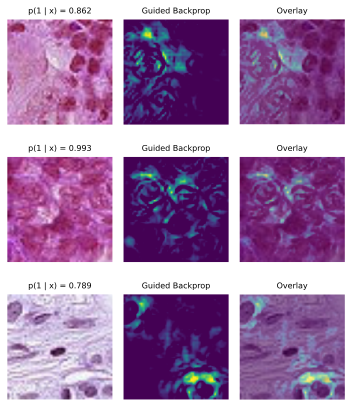

In [42]:
fig, ax = plt.subplots(num_samples, 3, figsize=(5, 6))
for b in range(num_samples):
    ax[b, 0].imshow(normalize(outs[b]["x"]).detach().permute(1, 2, 0).cpu().numpy())
    ax[b, 1].imshow(standardize_and_clip(outs[b]["g"], min_val=min_val, max_val=max_val).cpu().numpy(), cmap="viridis")
    ax[b, 2].imshow(normalize(outs[b]["x"]).detach().permute(1, 2, 0).cpu().numpy())
    ax[b, 2].imshow(standardize_and_clip(outs[b]["g"], min_val=min_val, max_val=max_val).cpu().numpy(), cmap="viridis", alpha=overlay_alpha)
    ax[b, 0].axis("off")
    ax[b, 1].axis("off")
    ax[b, 2].axis("off")
    ax[b, 0].set_title(f"p({target} | x) = {outs[b]['p']:.3f}", size=8)
    ax[b, 1].set_title("Guided Backprop", size=8)
    ax[b, 2].set_title("Overlay", size=8)

fig.tight_layout()

Not a domain expert on histopathology,
so let us compare how this looks like with pretrained AlexNet on a dog image.

In [43]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

image = cv2.imread('./data/shorty.png')
x = transform(image).unsqueeze(0).to(DEVICE)
x.requires_grad = True

alexnet = models.alexnet(pretrained=True).to(DEVICE)
out = guided_backprop(alexnet, x, target=None)

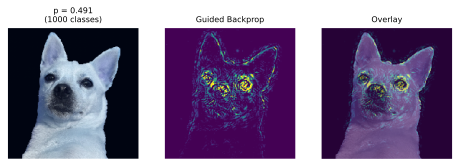

In [44]:
min_val = 0.5
max_val = 10.0
overlay_alpha = 0.75
fig, ax = plt.subplots(1, 3, figsize=(8, 10))
ax[0].imshow(normalize(out["x"]).detach().permute(1, 2, 0).cpu().numpy())
ax[1].imshow(standardize_and_clip(out["g"], min_val=min_val, max_val=max_val).cpu().numpy(), cmap="viridis")
ax[2].imshow(normalize(out["x"]).detach().permute(1, 2, 0).cpu().numpy())
ax[2].imshow(standardize_and_clip(out["g"], min_val=min_val, max_val=max_val).cpu().numpy(), cmap="viridis", alpha=overlay_alpha)
ax[0].axis("off")
ax[1].axis("off")
ax[2].axis("off")
ax[0].set_title(f"p = {out['p']:.3f}\n(1000 classes)", size=8)
ax[1].set_title("Guided Backprop", size=8)
ax[2].set_title("Overlay", size=8);

**Remark.** It's interesting that the model can pick out the whiskers from the input image.

## Appendix: Text classification

In this section, we train a convolutional network on text embeddings. In particular, our dataset consist of Spanish given names downloaded from https://github.com/jvalhondo/spanish-names-surnames. Our task is to classify names into its gender label given in this dataset.

In [45]:
!wget -O ./data/spanish-male-names.csv https://raw.githubusercontent.com/jvalhondo/spanish-names-surnames/master/male_names.csv
!wget -O ./data/spanish-female-names.csv https://raw.githubusercontent.com/jvalhondo/spanish-names-surnames/master/female_names.csv

--2024-01-08 19:35:30--  https://raw.githubusercontent.com/jvalhondo/spanish-names-surnames/master/male_names.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 491187 (480K) [text/plain]
Saving to: ‘./data/spanish-male-names.csv’

./data/spanish-male 100%[===================>] 479.67K  --.-KB/s    in 0.08s   

2024-01-08 19:35:30 (5.60 MB/s) - ‘./data/spanish-male-names.csv’ saved [491187/491187]

--2024-01-08 19:35:30--  https://raw.githubusercontent.com/jvalhondo/spanish-names-surnames/master/female_names.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, await

In [46]:
dfm = pd.read_csv(DATASET_DIR / "spanish-male-names.csv")
dff = pd.read_csv(DATASET_DIR / "spanish-female-names.csv")

dfm = dfm[['name']].dropna(axis=0, how="any")
dff = dff[['name']].dropna(axis=0, how="any")
dfm['gender'] = 'M'
dff['gender'] = 'F'

df = pd.concat([dfm, dff], axis=0)
df['name'] = df.name.map(lambda s: s.replace(" ", "_").lower())
df = df.drop_duplicates().reset_index()
df

index          name gender
0          0       antonio      M
1          1          jose      M
2          2        manuel      M
3          3     francisco      M
4          4          juan      M
...      ...           ...    ...
49334  24751        zhihui      F
49335  24752  zoila_esther      F
49336  24753       zsanett      F
49337  24754        zuleja      F
49338  24755       zulfiya      F

[49339 rows x 3 columns]

In [47]:
df.gender.value_counts()

gender
F    24755
M    24584
Name: count, dtype: int64

Looking at name lengths. The following histogram is multimodal due to having multiple subnames
separated by space.

Max name length: 27


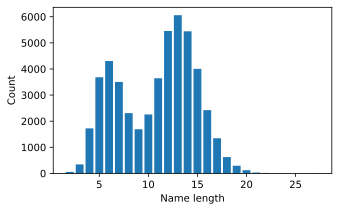

In [48]:
from collections import Counter

name_length = Counter([len(n) for n in df.name])
lengths = sorted(name_length.keys())
plt.figure(figsize=(5, 3))
plt.bar(lengths, [name_length[k] for k in lengths])
plt.xlabel("Name length")
plt.ylabel("Count")
print("Max name length:", max(lengths))

In [49]:
len(df[df.name.apply(len) < 23]) / len(df)

0.9997365167514543

We will pad names with `.` at the end so that we get same length names. Moreover, we will truncate names to a max length. This is typical for language models due to architectural constraints. In any case, considering a sufficiently large fixed number of initial characters of a name should be enough to determine the label.

In [50]:
MAX_LEN = 22
CHARS = ['.'] + sorted(list(set([c for n in df.name for c in n])))
VOCAB_SIZE = len(CHARS)

print("token count:", VOCAB_SIZE)
print("".join(CHARS))

token count: 31
.'_abcdefghijklmnopqrstuvwxyzçñ


### Data loaders

In [51]:
from torch.utils.data import Dataset, DataLoader

class NamesDataset(Dataset):
    def __init__(self, names: list[str], label: list[int]):
        self.char_to_int = {c: i for i, c in enumerate(CHARS)}
        self.data = torch.tensor([self.encode(name) for name in names])
        self.label = torch.tensor(label)

    def encode(self, name: str):
        return [self.char_to_int[char] for char in self.preprocess(name)]

    def decode(self, x: torch.Tensor):
        int_to_char = {i: c for c, i in self.char_to_int.items()}
        return "".join(int_to_char[i.item()] for i in x)
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.label[idx]

    @staticmethod
    def preprocess(name):
        out = [c for c in name if c in CHARS]
        return "." + "".join(out)[:min(len(out), MAX_LEN)] + "." * (MAX_LEN - len(out))


label_map = lambda t: 1 if t == "F" else 0
g = torch.Generator().manual_seed(RANDOM_SEED)
names = df.name.tolist()
label = list(map(label_map, df.gender.tolist()))

names_dataset = NamesDataset(names, label)
names_train_dataset, names_valid_dataset = random_split(names_dataset, [0.8, 0.2], generator=g)
names_train_loader = DataLoader(names_train_dataset, batch_size=32, shuffle=True)
names_valid_loader = DataLoader(names_valid_dataset, batch_size=32, shuffle=False)

Sample instance:

In [52]:
x, y = next(iter(names_train_loader))
x[0], y[0]

(tensor([ 0, 12, 17, 10, 16,  2,  3, 16,  6, 20,  7, 25,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0]),
 tensor(0))

Decoding:

In [53]:
name = names_dataset.decode(x[0])
name, "F" if label_map(y[0].item()) == 1 else "M"

('.john_andrew...........', 'M')

### Model

For each token (i.e. character in `CHARS`) we learn an embedding vector in $\mathbb{R}^{10}.$ The convolution kernel runs across a context of characters with stride 1. Subnames are short, so a context size of 3 or 4 should be good. This is implemented below with a 1D convolution with kernel size equal to context size times the embedding size, and a stride equal to the embedding size ({numref}`03-text-cnn`). 

```{figure} ../../img/nn/03-text-cnn.png
---
width: 740px
name: 03-text-cnn
---

Model architecture to classify text using convolutions. The kernel slides over embeddings instead of pixels. [Source](https://lena-voita.github.io/nlp_course/models/convolutional.html#text_classification)
```

Hence, the model determines the gender label of a name by looking at the presence of certain n-grams in a name, regardless of its position in the name. This is done using **max pool over time** ({numref}`03-maxpool-over-time`) which reduces the feature map to a vector of length equal to the output channel of the 1D convolution.

```{figure} ../../img/nn/03-maxpool-over-time.png
---
width: 500px
name: 03-maxpool-over-time
---

Max pooling over time reduces the feature map to a vector whose entries correspond to the largest value in each output channel over the entire sequence. [Source](https://lena-voita.github.io/nlp_course/models/convolutional.html#text_classification)
```

Note that we learn **embeddings** because some characters may be similar in the context of this task. The model gets to learn vector representations such that similar characters will have similar embeddings. In contrast, one-hot vector representations are fixed to be mutually orthogonal. The model is implemented as follows:

In [54]:
import torchinfo

class CNNModel(nn.Module):
    def __init__(self, vocab_size=VOCAB_SIZE, context=3, embedding_dim=10, conv_width=64, fc_width=256):
        super().__init__()
        self.vocab_size = vocab_size
        self.emb = embedding_dim
        self.context = context

        self.C = nn.Embedding(num_embeddings=self.vocab_size, embedding_dim=self.emb)
        self.conv1 = nn.Conv1d(1, conv_width, kernel_size=self.context * self.emb, stride=self.emb)
        self.relu1 = nn.ReLU()
        self.pool_over_time = nn.MaxPool1d(kernel_size=MAX_LEN - self.context + 1)

        self.fc = nn.Sequential(
            nn.Linear(conv_width, fc_width),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(fc_width, 2)
        )

    def forward(self, x):
        B = x.shape[0]
        x = self.C(x)
        x = x.reshape(B, 1, -1)
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool_over_time(x)
        return self.fc(x.reshape(B, -1))


torchinfo.summary(CNNModel(), input_size=(1, MAX_LEN + 1), dtypes=[torch.int64])

Layer (type:depth-idx)                   Output Shape              Param #
CNNModel                                 [1, 2]                    --
├─Embedding: 1-1                         [1, 23, 10]               310
├─Conv1d: 1-2                            [1, 64, 21]               1,984
├─ReLU: 1-3                              [1, 64, 21]               --
├─MaxPool1d: 1-4                         [1, 64, 1]                --
├─Sequential: 1-5                        [1, 2]                    --
│    └─Linear: 2-1                       [1, 256]                  16,640
│    └─ReLU: 2-2                         [1, 256]                  --
│    └─Dropout: 2-3                      [1, 256]                  --
│    └─Linear: 2-4                       [1, 2]                    514
Total params: 19,448
Trainable params: 19,448
Non-trainable params: 0
Total mult-adds (M): 0.06
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.08
Estimated Total Size (MB): 0.09

### Training

In [55]:
model = CNNModel(conv_width=128, context=4, fc_width=256)
optim = torch.optim.Adam(model.parameters(), lr=0.001)
trainer = Trainer(model, optim, loss_fn=F.cross_entropy)
trainer.run(epochs=5, train_loader=names_train_loader, valid_loader=names_valid_loader)

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 1/5]    loss: 0.2026  acc: 0.9073    val_loss: 0.2100  val_acc: 0.9090
[Epoch: 2/5]    loss: 0.1741  acc: 0.9185    val_loss: 0.1767  val_acc: 0.9223
[Epoch: 3/5]    loss: 0.1659  acc: 0.9319    val_loss: 0.1715  val_acc: 0.9254
[Epoch: 4/5]    loss: 0.1819  acc: 0.9150    val_loss: 0.1655  val_acc: 0.9250
[Epoch: 5/5]    loss: 0.1633  acc: 0.9278    val_loss: 0.1591  val_acc: 0.9307


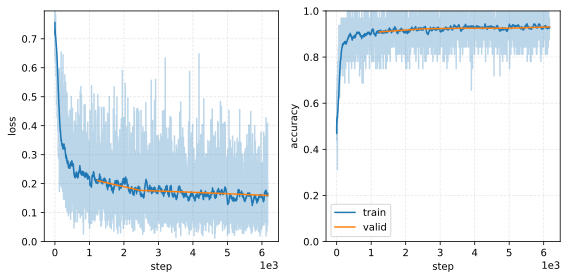

In [56]:
plot_training_history(trainer)

### Inference

In [57]:
data = [ 
    "maria",
    "clara",
    "maria_clara",
    "tuco",
    "salamanca",
    "tuco_salamanca",
]

# Model prediction
x = torch.tensor([names_dataset.encode(n) for n in data])
probs = F.softmax(trainer.predict(x), dim=1)[:, 1].cpu()  # p(F|name)

In [58]:
print("name                         p(F|name)")
print("--------------------------------------")
for i, name in enumerate(data):
    print(f"{name + ' ' * (MAX_LEN - len(name))} \t\t {probs[i]:.3f}")

name                         p(F|name)
--------------------------------------
maria                  		 0.949
clara                  		 0.984
maria_clara            		 1.000
tuco                   		 0.398
salamanca              		 0.851
tuco_salamanca         		 0.097


**Remark.** The model seems to compose inputs well since the model is able to perform convolution over spaces.

---
■